<a href="https://colab.research.google.com/github/qa21336/HousingStatisticsAnalysis-/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preproccessing

Need data in (batch, timesteps, feature) format.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ADS Datasets/cleaned_interpolated.csv')
df.head()

,Year,country,Persons,Males,Females,affordability,Started - All Dwellings,Completed - All Dwellings,mm/yyyy,employment_rate,inflation_rate,AveragePrice,SalesVolume,NewSalesVolume,OldSalesVolume
0,2001,E,49449746.00,2.416559e+07,2.528416e+07,4.500000,146770.0,129510.0,01/2001,72.7,0.9,96649.186160,717.574850,55.428144,662.146707
1,2001,E,49468872.75,2.417618e+07,2.529269e+07,4.551667,147097.5,130117.5,02/2001,72.6,0.8,96675.059120,741.808383,71.586826,670.221557
2,2001,E,49487999.50,2.418678e+07,2.530122e+07,4.603333,147425.0,130725.0,03/2001,72.6,0.9,97172.835571,995.470060,109.086826,886.383234
3,2001,E,49507126.25,2.419738e+07,2.530975e+07,4.655000,147752.5,131332.5,04/2001,72.7,1.2,98461.905336,976.658683,88.502994,888.155689
4,2001,E,49526253.00,2.420798e+07,2.531828e+07,4.706667,148080.0,131940.0,05/2001,72.7,1.7,100160.766675,1097.919162,100.482036,997.437126


Different models for different countries, so lets start with England.

Also, drop AveragePrice to make it a fair test.

Then Train-Test split.

In [3]:
import numpy as np

dfEngland = df.loc[df["country"] == "E"].drop(["country", "AveragePrice", "Year", "mm/yyyy"], axis=1)
affordEng = dfEngland.pop("affordability")

Add a column for next years affordability.

In [34]:
# Make next years affordability and remove last datapoint (so dims line up)
nyAffordEng = affordEng[12:]
newDfEngland = dfEngland[:-1]

# Convert to numpy
dfEnglandnp = np.array(newDfEngland)
print(dfEnglandnp.shape)

affordEngnp = np.array(nyAffordEng)
print(affordEngnp.shape)

(227, 10)
(216,)


In [35]:
n = dfEnglandnp.shape[0]
p = dfEnglandnp.shape[1]
train_test_cutoff = int((0.8 * n) / 12) * 12 # Multiple of 12

dfEnglandTrain = dfEnglandnp[:train_test_cutoff]
dfEnglandTest = dfEnglandnp[train_test_cutoff:]
affordEngTrain = affordEngnp[:train_test_cutoff]
affordEngTest = affordEngnp[train_test_cutoff:]

print(dfEnglandTrain.shape)
print(dfEnglandTest.shape)
print(affordEngTrain.shape)
print(affordEngTest.shape)

(180, 10)
(47, 10)
(180,)
(36,)


In [40]:
# Save normalisation constants
dfEnglandTrMean = np.mean(dfEnglandTrain, axis=0)
dfEnglandTrStd = np.std(dfEnglandTrain, axis=0)

# Do normalisation (use same constansts for test)
dfEnglandTrNorm = (dfEnglandTrain - dfEnglandTrMean) / dfEnglandTrStd
dfEnglandTestNorm = (dfEnglandTest - dfEnglandTrMean) / dfEnglandTrStd
dfEnglandWholeNorm = (newDfEngland - dfEnglandTrMean) / dfEnglandTrStd

Now to reshape to (batch, timesteps, feature).

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

windowSize = 12 # One year

train = timeseries_dataset_from_array(dfEnglandTrNorm,
                                        affordEngTrain,
                                        windowSize,
                                        batch_size=1)

test = timeseries_dataset_from_array(dfEnglandTestNorm,
                                        affordEngTest,
                                        windowSize,
                                        batch_size=1)

whole = timeseries_dataset_from_array(dfEnglandWholeNorm,
                                        None,
                                        windowSize,
                                        batch_size=1)

print(len(list(test)))
for features, labels in test.take(1):
    print(features.shape)
    print(labels.shape)

36
(1, 12, 10)
(1,)


# LSTM Time

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, input_shape=(12, 10)),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')

model.fit(train, epochs=20)

Epoch 1/20
169/169 [==============================] - 3s 6ms/step - loss: 37.8635
Epoch 2/20
169/169 [==============================] - 1s 6ms/step - loss: 18.3255
Epoch 3/20
169/169 [==============================] - 1s 7ms/step - loss: 3.4382
Epoch 4/20
169/169 [==============================] - 1s 9ms/step - loss: 0.5215
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1613
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1477
Epoch 7/20
169/169 [==============================] - 1s 5ms/step - loss: 0.1273
Epoch 8/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1115
Epoch 9/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1013
Epoch 10/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0921
Epoch 11/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0822
Epoch 12/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0712
Epoch 13/20
169/169 [==

# Predict and Plot

216/216 [==============================] - 0s 2ms/step
(216,)
(216,)


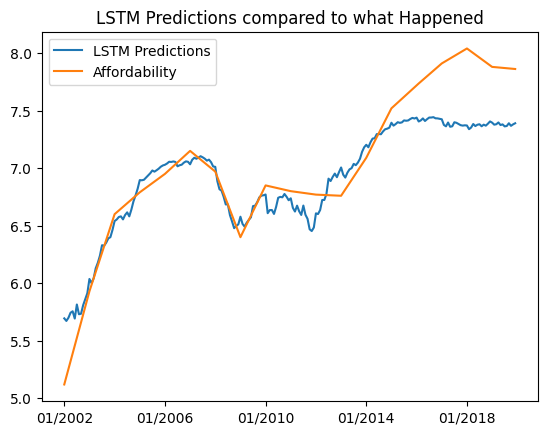

In [53]:
import matplotlib.pyplot as plt

preds = model.predict(whole).reshape(-1,)

# 12 month shift because predictions are for 12 months in future
x_axis = (((df.loc[df["country"] == "E"])["mm/yyyy"])[12:])
afford_line = (((df.loc[df["country"] == "E"])["affordability"])[12:])

print(x_axis.shape)
print(preds.shape)

plt.xticks([i for i in range(0, 240, 48)])
plt.plot(x_axis, preds, label="LSTM Predictions")
plt.plot(x_axis, afford_line, label="Affordability")
plt.legend()
plt.title("LSTM Predictions compared to what Happened")

plt.show()